<a href="https://colab.research.google.com/github/rabiaozdemir/Transfer_Learning/blob/main/Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:





import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Model,Sequential
from keras.applications import xception, vgg16, mobilenet
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D,GlobalAveragePooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
train_path="./drive/MyDrive/chest_xray/train"
test_path="./drive/MyDrive/chest_xray/test"

trainDataGen=ImageDataGenerator(rescale=1./255, validation_split=0.1)
testDataGen=ImageDataGenerator(rescale=1./255)

trainGen=trainDataGen.flow_from_directory(
    train_path,
    target_size=(299,299),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=128,
    subset="training"
    )

valGen=trainDataGen.flow_from_directory(
    train_path,
    target_size=(299,299),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=128,
    subset="validation"
)

testGen=testDataGen.flow_from_directory(
    test_path,
    target_size=(299,299),
    color_mode='rgb',
    class_mode="categorical",
    batch_size=1
    )

Found 4711 images belonging to 3 classes.
Found 521 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [6]:
model =xception.Xception(weights='imagenet', include_top=False)
print (model.summary())


Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [7]:
for layers in model.layers:
    layers.trainable=False  

In [8]:
# yeni katmanlar ekleyelim
x=model.output
x=GlobalAveragePooling2D()(x)
x=Dense(512,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(256,activation='relu')(x)
x=Dropout(0.2)(x)
x=Dense(128,activation='relu')(x)
x=Dropout(0.2)(x)
output=Dense(3,activation='softmax')(x)


In [9]:
New_Model=Model(model.input,output)


In [10]:
print (New_Model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [11]:
New_Model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=["accuracy"])
history=New_Model.fit(
 trainGen,
 steps_per_epoch=trainGen.samples//128,
 epochs=5,
 validation_data=valGen,
 validation_steps=valGen.samples//128,
 #shuffle=True,
 #callbacks=[checkpoint]
 )


Epoch 1/5
36/36 [==============================] - 1721s 47s/step - loss: 0.8157 - accuracy: 0.6175 - val_loss: 0.4423 - val_accuracy: 0.8535
Epoch 2/5
36/36 [==============================] - 1637s 46s/step - loss: 0.5309 - accuracy: 0.7699 - val_loss: 0.4284 - val_accuracy: 0.8203
Epoch 3/5
36/36 [==============================] - 1649s 46s/step - loss: 0.4986 - accuracy: 0.7854 - val_loss: 0.3576 - val_accuracy: 0.8691
Epoch 4/5
36/36 [==============================] - 1733s 48s/step - loss: 0.4669 - accuracy: 0.7965 - val_loss: 0.3689 - val_accuracy: 0.8770
Epoch 5/5
36/36 [==============================] - 1738s 48s/step - loss: 0.4492 - accuracy: 0.7964 - val_loss: 0.3569 - val_accuracy: 0.8691


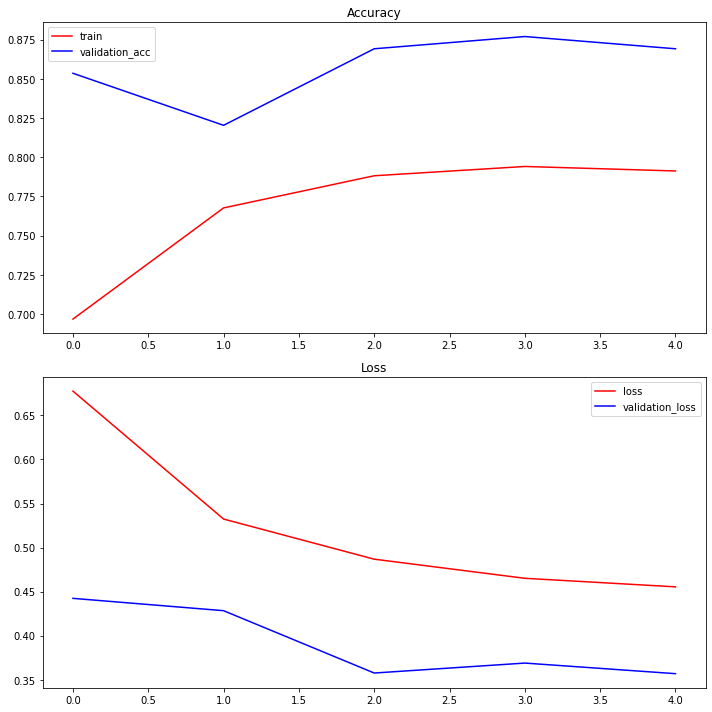

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["accuracy"], color='r',label='train')
plt.plot(history.history["val_accuracy"], color='b',label='validation_acc')
plt.legend(loc='best')
plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color='r',label='loss')
plt.plot(history.history["val_loss"], color='b',label='validation_loss')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [17]:
#CONFUSİON MATRİX ÇİZDİRME
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
Y_pred = New_Model.predict_generator(testGen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(testGen.classes, y_pred)
print(cm)

print('Classification Report')
print(classification_report(testGen.classes, y_pred))


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[141  43  53]
 [116  48  70]
 [ 78  36  39]]
Classification Report
              precision    recall  f1-score   support

           0       0.42      0.59      0.49       237
           1       0.38      0.21      0.27       234
           2       0.24      0.25      0.25       153

    accuracy                           0.37       624
   macro avg       0.35      0.35      0.34       624
weighted avg       0.36      0.37      0.35       624

